circle_area 468.1 div contour_area 397.5 = 0.85
circle_area 352.78 div contour_area 283.0 = 0.8
circle_area 689.62 div contour_area 542.5 = 0.79
circle_area 536.23 div contour_area 468.0 = 0.87
circle_area 680.17 div contour_area 586.0 = 0.86
circle_area 2319.31 div contour_area 1100.0 = 0.47
circle_area 374.64 div contour_area 306.5 = 0.82
circle_area 557.04 div contour_area 469.0 = 0.84
circle_area 679.38 div contour_area 493.0 = 0.73


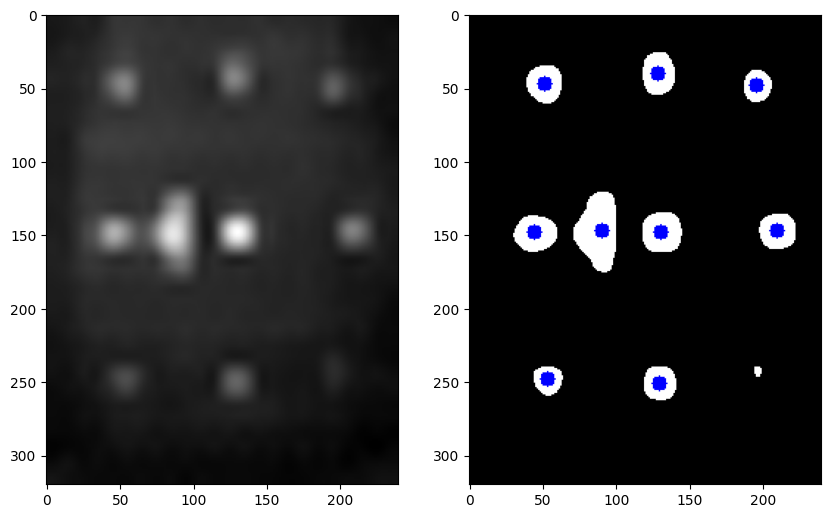

circle_area 2426.11 div contour_area 1283.0 = 0.53
circle_area 858.93 div contour_area 674.5 = 0.79
circle_area 719.52 div contour_area 643.5 = 0.89
circle_area 818.39 div contour_area 590.0 = 0.72
circle_area 669.99 div contour_area 586.5 = 0.88
circle_area 570.06 div contour_area 428.5 = 0.75
circle_area 581.2 div contour_area 415.5 = 0.71
circle_area 422.25 div contour_area 349.0 = 0.83
circle_area 410.31 div contour_area 345.0 = 0.84
circle_area 219.03 div contour_area 184.0 = 0.84


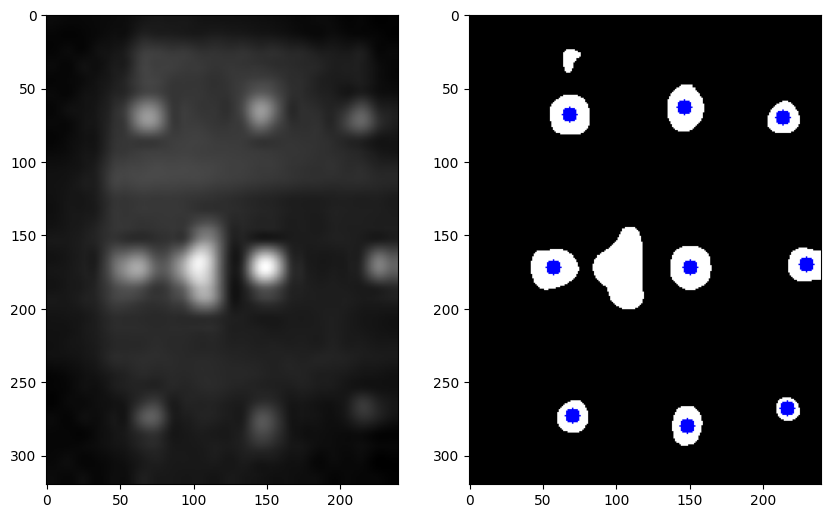

circle_area 519.2 div contour_area 460.0 = 0.89
circle_area 234.86 div contour_area 162.0 = 0.69
circle_area 330.0 div contour_area 211.5 = 0.64
circle_area 517.87 div contour_area 426.5 = 0.82
circle_area 510.7 div contour_area 424.5 = 0.83
circle_area 726.61 div contour_area 668.0 = 0.92
circle_area 2417.52 div contour_area 1170.5 = 0.48
circle_area 328.62 div contour_area 268.0 = 0.82
circle_area 342.91 div contour_area 277.5 = 0.81
circle_area 582.81 div contour_area 406.5 = 0.7


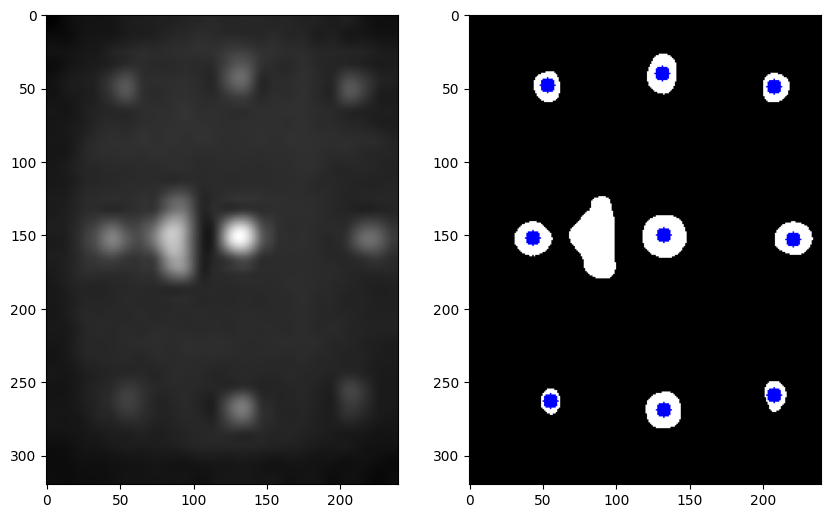

circle_area 791.32 div contour_area 569.5 = 0.72
circle_area 422.55 div contour_area 370.5 = 0.88
circle_area 438.41 div contour_area 353.5 = 0.81
circle_area 547.35 div contour_area 483.5 = 0.88
circle_area 523.08 div contour_area 440.0 = 0.84
circle_area 833.64 div contour_area 713.0 = 0.86
circle_area 2063.26 div contour_area 952.0 = 0.46
circle_area 304.01 div contour_area 245.5 = 0.81
circle_area 360.04 div contour_area 299.0 = 0.83
circle_area 409.26 div contour_area 325.5 = 0.8


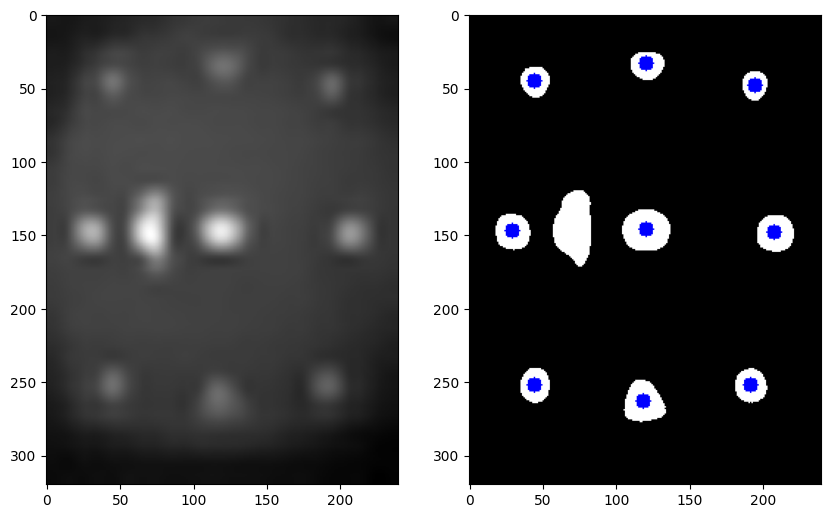

circle_area 1690.19 div contour_area 952.0 = 0.56
circle_area 1179.3 div contour_area 696.0 = 0.59
circle_area 794.09 div contour_area 688.5 = 0.87
circle_area 1038.4 div contour_area 594.0 = 0.57
circle_area 969.19 div contour_area 548.0 = 0.57
circle_area 581.2 div contour_area 502.5 = 0.86
circle_area 515.23 div contour_area 450.0 = 0.87
circle_area 457.78 div contour_area 391.5 = 0.86
circle_area 374.27 div contour_area 319.0 = 0.85
circle_area 282.75 div contour_area 237.0 = 0.84


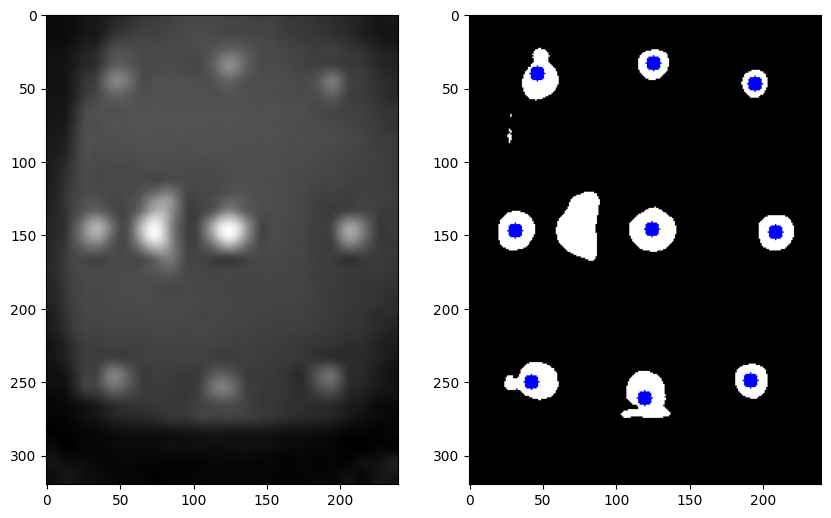

In [2]:
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from calibration_utils import load_thermal_image


MINIMAL_THERMAL_CONTOUR_AREA = 90
MAXIMAL_THERMAL_CONTOUR_AREA = 2000
FULFILMENT_THERMAL_THRESHOLD = 0.4

NUMBER_OF_CALIBRATION_POINTS = 9
NUMBER_OF_CP_WITH_TRIANGLE = 10

THERMAL_THRESOLD_KERNEL_HYDRA = 171
THERMAL_THRESOLD_C_HYDRA = -20

THERMAL_THRESOLD_KERNEL_HUB = 171
THERMAL_THRESOLD_C_HUB = -20


def find_calibration_points_on_heatmap(image: cv2.Mat, is_hydra=True):
    """Find nine points on a calibration image.

    Args:
        image (cv2.Mat): calibration image 
        is_thermal_image (bool): is this heatmap a thermal image or rgb image

    Returns:
        coordinates - sorted list of calibration point coordinates
        thermal_rgb - rgb version of a image - for debugging
        thresh_rgb - rgb version of thresholded image - for debugging
    """
    image_8u = np.uint8(image)

    if image_8u.ndim == 3:
        image_rgb = image_8u.copy()
        image_8u = cv2.cvtColor(image_8u, cv2.COLOR_RGB2GRAY)
    else:
        image_rgb = cv2.cvtColor(image_8u, cv2.COLOR_GRAY2RGB)

    if is_hydra:
        thresh = cv2.adaptiveThreshold(
            image_8u, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, THERMAL_THRESOLD_KERNEL_HYDRA, THERMAL_THRESOLD_C_HYDRA)
    else:
        thresh = cv2.adaptiveThreshold(
            image_8u, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, THERMAL_THRESOLD_KERNEL_HUB, THERMAL_THRESOLD_C_HUB)   
    

    thresh_8u = np.uint8(thresh)

    if is_hydra:    
        kernel = np.ones((3,3))
        thresh_8u = cv2.erode(thresh_8u, kernel=kernel, iterations=1)
        thresh_8u = cv2.dilate(thresh_8u, kernel=kernel, iterations=1)

    thresh_rgb = cv2.cvtColor(thresh_8u, cv2.COLOR_GRAY2RGB)

    contours = cv2.findContours(
        thresh_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    contours = [contour for contour in contours]

    # In case of small reflections on box walls
    if len(contours) > NUMBER_OF_CP_WITH_TRIANGLE:
        contours.sort(key=lambda contour: cv2.contourArea(contour), reverse=True)
        contours = contours[:NUMBER_OF_CP_WITH_TRIANGLE]

    coordinates = []

    # we now want to filter out noise
    for c in contours:
        correct_contour = validate_contour(c, MINIMAL_THERMAL_CONTOUR_AREA, MAXIMAL_THERMAL_CONTOUR_AREA, FULFILMENT_THERMAL_THRESHOLD)
        if correct_contour:
            ((x, y), _) = cv2.minEnclosingCircle(c)
            coordinates.append((int(x), int(y)))

    if len(coordinates) == NUMBER_OF_CALIBRATION_POINTS:
        coordinates = sort_calibration_points(coordinates)
    elif len(coordinates) == NUMBER_OF_CP_WITH_TRIANGLE:
        coordinates = sort_calibration_points_remove_triangle(coordinates)

    for x, y in coordinates:
        cv2.circle(thresh_rgb, (x, y), 0, (0, 0, 255), 10)

    return coordinates, image_rgb, thresh_rgb


def sort_calibration_points(points: list[(int, int)]):
    """ Sort array so points are in a following order:
        1 2 3
        4 5 6
        7 8 9
    Args:
        points (list[(int, int)]): list of points to be sorted
    Returns:
        points - sorted points
    """
    points.sort(key=lambda coordinate: coordinate[1])
    points[0:3] = sorted(points[0:3], key=lambda coordinate: coordinate[0])
    points[3:6] = sorted(points[3:6], key=lambda coordinate: coordinate[0])
    points[6:9] = sorted(points[6:9], key=lambda coordinate: coordinate[0])
    return points


def sort_calibration_points_remove_triangle(points: list[(int, int)]):
    """ Sort array so points are in a following order:
        1 2 3
        4 5 6 7
        8 9 10
        Then remove point 5 (triangle)
    Args:
        points (list[(int, int)]): list of points to be sorted
    Returns:
        points - sorted points
    """
    points.sort(key=lambda coordinate: coordinate[1])
    points[0:3] = sorted(points[0:3], key=lambda coordinate: coordinate[0])
    points[3:7] = sorted(points[3:7], key=lambda coordinate: coordinate[0])
    points[7:10] = sorted(points[7:10], key=lambda coordinate: coordinate[0])
    points.pop(4)
    return points


def validate_contour(contour, minimal_size: int, maximal_size: int, fulfilment_threshold: float):
    """Check if contour has correct shape and size

    Args:
        contour (cv2.Mat): validated contour
        minimal_size (int): minimal area of contour 
        maximal_size (int): maximal area of contour
        fulfilment_threshold (float): values <0,1> - accept shapes that are more similar to circle than this value 

    Returns:
        True if contour is valid, False otherwise
    """

    contour_area = cv2.contourArea(contour)

    _, r = cv2.minEnclosingCircle(contour)

    circle_area = math.pi*r*r

    percentage_of_fulfilment = contour_area/circle_area

    if minimal_size <= contour_area <= maximal_size and percentage_of_fulfilment >= fulfilment_threshold:
        print(f"circle_area {round(circle_area,2)} div contour_area {round(contour_area,2)} = {round(percentage_of_fulfilment,2)}")

    return minimal_size <= contour_area <= maximal_size and percentage_of_fulfilment >= fulfilment_threshold


def test_thermal(path, is_hydra):
    thermal_1 = load_thermal_image(path)

    _, thermal_raw_1, thermal_tresh_1 = find_calibration_points_on_heatmap(thermal_1, is_hydra)

    _, axs1 = plt.subplots(1, 2, figsize=(10,15))

    axs1[0].imshow(thermal_raw_1)

    axs1[1].imshow(thermal_tresh_1)

    plt.show()


test_thermal('wip_dataset/thermal/hydra_3.npy', is_hydra=True)
test_thermal('wip_dataset/thermal/hydra_6.npy', is_hydra=True)
test_thermal('wip_dataset/thermal/hub_1.npy', is_hydra=False)
test_thermal('wip_dataset/thermal/hub_2.npy', is_hydra=False)
test_thermal('wip_dataset/thermal/hub_3.npy', is_hydra=False)